<a href="https://colab.research.google.com/github/StevenXDiaz/AstroPersonalWebsite/blob/main/MSE233_HW3_Spring2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MS&E 233 (Spring 2025): Homework 3 (due April 30th, 8:00pm)

# Problem 1 (2 points)

In this problem we consider a simple variant of poker with just two players. The deck only contains 3 cards: King, Queen, and Jack, with King > Queen > Jack. At each round the players can either bet +1 or check (meaning their bid remains the same). Finally, the player with the largest bid wins and if both player have the same bid, they reveal their hand and the player with the highest value card wins. The winner gets back all the money they bid in addition to all the money that their opponent bid.

Now, the game procceds as follows:
- Player 1 and Player 2 bid 1 each
- Both players are dealt a card each from the deck
- Case 1: Player 1 chooses to check
  - Case 1.1: Player 2 chooses to check
    - The players reveal their hand and the one with the higher card wins
  - Case 1.2: Player 2 chooses to bid 1
    - Case 1.2.1: Player 1 chooses to check
      - Player 2 wins
    - Case 1.2.2: Player 1 chooses to bid 1
      - The players reveal their hand and the one with the higher card wins
- Case 2: Player 1 chooses to bid 1
 - Case 2.1: Player 2 chooses to check
    - Player 1 wins
 - Case 2.2: Player 2 chooses to bid 1
    - The players reveal their hand and the one with the higher card wins


Notation: let's represent the chance nodes with values 'r', bid with 'b' and check with 'c'. If the current player is player 2 and holds a Queen and the history was 'b' by player 1, then the history is 'rrb', i.e. two chance events happened (giving both player a card each) and then the first player bid. There is a dictionary keeping track of the information set, then this set is indexed by the string 'Q rrb'.


Draw and upload a picture of the game tree for this incomplete information extensive-form game (Hint: the game has 12 information sets; excluding the root chance node, make sure to mark them!)

# Problem 2 - CFRM for Poker (total of 10 points)

## CFRM and CFRM+ Implementation

We will implement the algorithm described in slides 61-71 of Lecture 6

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def is_chance_node(history):
    '''
    The chance node is the first node, so to check if we are at the chance node,
    it suffices to check if the history is empty or not.
    Checks if history is empty of not.

    Inputs: history (str)
    Output: True/False
    '''
    if history == "":
        return True
    else:
        return False

def is_terminal_node(history):
    '''
    This function checks if we are at a terminal node in the game tree or not.
    There are only 4 possible terminal nodes, and we check if the current node is one of them.

    Inputs: history (str)
    Output: True/False
    '''
    if history in ["rrcc", "rrbc", "rrbb", "rrcbc", "rrcbb"]:
        return True
    else:
        return False

In [31]:
class InformationSet:
    '''This class stores all information & methods corresponding to a given information set'''
    def __init__(self):
        # initially we play the random strategy
        self.strategies = np.ones(2) / 2
        # the "local utility" for each action, i.e. vector of quantities tilde{u}_a
        # from the slides. Initialized to 0
        self.utilities = np.zeros(2)

        # the product of probabilities of my own actions on the path to this
        # infoset; aka reach probability q(I). Corresponds to the sequence form
        # strategy of the parent node of this infoset, i.e. tilde{x}_{p_I} in slides
        # This is required for calculating the equilibrium at the end of training as
        # the weighted average of behavioral strategies weighted by the reach
        # probability.
        self.pr_reach = 0

        # The cumulative regret stores the cumulative regret over training periods.
        # This is the quantity R_{t,a} in the slides.
        # initialized to 0
        self.cum_regret = np.zeros(2)

        # cumulative strategies, and cumulative reach
        # probabilities are used to find the weighted average of strategies
        #   weighted average strategy = equilibrium behavioral strategy
        # at the end of training cum_strategies should hold the numerator
        # and cum_pr_reach should hold the denominator of the fraction that forms
        # the equilibrium strategy, i.e.
        #   equilibrium_behavioral_strategy = cum_strategies / cum_pr_reach
        self.cum_strategies = np.zeros(2)
        self.cum_pr_reach = 0

    def next_strategy(self, update_type='RM'):
        '''(2.5 points)'''
        # update type is either RM (for counterfactual regret minimization)
        # or RM+ (for optimistic counterfactual regret minimization)

        # First we keep track of the weighted cumulative strategies
        # and the sum of weights of the prior strategy, before updating.
        # At this step the reach probability has been calculated based on the prior
        # period strategy. So self.pr_reach should be the quantity q_{t-1}(I) as
        # calculated based on strategies x_{t-1} and the self.strategies should
        # contain the local behavioral strategy at infoset I at period t-1.
        self.cum_strategies += self.pr_reach * self.strategies
        self.cum_pr_reach += self.pr_reach

        regrets = self.utilities - self.get_avg_utility(self.utilities)

        # increment self.cum_regret based on utilities and the update type
        if update_type == 'RM':
            self.cum_regret += regrets

        elif update_type == 'RM+':
            # optimistic regret minimization only keeps track of positive values
            self.cum_regret = np.maximum(self.cum_regret + regrets, 0)

        # q-values = the positive cumulative regrets
        q_value = self.cum_regret.clip(0)
        s = sum(q_value)
        if s != 0:
            # now compute self.strategies based on the regret values
            self.strategies = q_value / s

        # reset utilities and reach probabilities for the next iteration
        self.utilities = np.zeros(2)
        self.pr_reach = 0

    def update_utilities(self, other_prob, cvalues):
        '''
        (0.5 points)
        other_prob: the product of probabilities of opponent or chance on the path
            to this infoset
        cvalues: the vector of continuation values for each action available at this
            infoset
        '''
        self.utilities += other_prob * cvalues

    def update_pr_reach(self, p):
        ''' update the reach probability of the node, i.e. the quantity q(I) of slides'''
        self.pr_reach = p

    def get_strategy(self):
        ''' returns the current strategy for the information set '''
        return self.strategies

    def get_average_strategy(self):
        ''' returns the weighted average strategy '''
        return self.cum_strategies/self.cum_pr_reach

    def get_avg_utility(self, utilities):
        ''' returns the average utility for the current strategy'''
        return np.dot(utilities, self.strategies)

In [32]:
def terminal_util(player, card_p1, card_p2, history):
    '''
    Function returns the utility of player at a terminal node.
    Inputs:
    player: 1 or 2, the player whose terminal utility we want
    card_p1: the card that player 1 was dealt at the beginning
    card_p2: the card that player 2 was dealt at the beginning
    '''
    # we first compute terminal node utility for player 1
    # multiple that with -1 if we want utility for player 2 (because this is a zero-sum game)

    card_values = {"K" : 3, "Q" : 2, "J" : 1}
    # if last player checked while the second-last player bid,
    # then the default winner is the second-last player
    if history == "rrcbc":
        value = -1
    elif history == "rrbc":
        value = 1
    else:
        # showdown between two players to determine who won
        if card_values[card_p1] > card_values[card_p2]:
            player1_wins = 1
        else:
            player1_wins = -1
        if history == "rrcc":
            value = 1 * player1_wins
        elif history in ["rrcbb", "rrbb"]:
            value = 2 * player1_wins

    # if player = player 2, they get -1 * utility for player 1
    # because this is a zero-sum game
    if player == 1:
        return value
    else:
        return value * -1

def fetch_information_set(info_sets, index):
    '''
    Retreive the information set corresponding to the index that is
    stored in the dictionary info_sets. If such an information set doesn't
    exist, create and return a new instance of the class InformationSet

    Inputs: info_sets(dict): a dictionary of information sets indexed by
            a string representing the information set.
            index (str): the string representing the information set e.g. Q rrb
    Output: an instance of the class InformationSet
    '''
    if index not in info_sets:
        info_sets[index] = InformationSet()
    return info_sets[index]

In [33]:
def cvalue_p1(info_sets, history="", player1_prob=1, other_prob=1, player1_card=None, player2_card=None):
    '''
    (3.0 points)
    cvalue_p1 iteratively computes and returns the average utility for the given node for player 1.
    It also updates pr_reach and utilities for player 1.

    info_sets: dictionary of information sets
    history: history of the current node
    player1_prob: the product of probabilities of player 1 on the path to this infoset
    other_prob: the product of probabilities of opponent or chance on the path to this infoset
    player1_card: the card that player 1 was dealt at the beginning
    player2_card: the card that player 2 was dealt at the beginning
    '''
    # check if we are at the terminal node
    if is_terminal_node(history):
        # return the terminal node utility for player 1
        return terminal_util(1, player1_card, player2_card, history)

    # check if we are at the chance node
    if is_chance_node(history):
        # history string for the chance node
        history = "rr"
        # we start with zero expected value
        value = 0
        # iterate over all combination of cards nature can choose for the players
        for card_p1 in ['K', 'Q', 'J']:
            for card_p2 in ['K', 'Q', 'J']:
                if card_p1 != card_p2:

                    # recursively compute expected utility for player 1 for each sub node
                    value += (1/6) * cvalue_p1(info_sets, history, player1_prob, other_prob, card_p1, card_p2)

        # return average node utility for the chance node
        # this is also the value of the game, since it is the root
        return value

    # next set of actions
    actions = ['b', 'c']
    # utilities from taking the next set of actions
    utilities = np.zeros(2)
    # check if it is the 2nd player's chance
    if len(history) % 2 == 1:
        # get the information set for the current node
        info_set = fetch_information_set(info_sets, player2_card + " " + history)
        # get the t-1 strategy at current node
        strategies = info_set.get_strategy()
        # loop through both actions and find their utilities recursively
        for i in range(2):
          next_history = history + actions[i]
          utilities[i] = cvalue_p1(
              info_sets, next_history, player1_prob, other_prob * strategies[i],
              player1_card, player2_card)

    # check if it is the 1st player's chance
    else:
        # get the information set for the current node
        info_set = fetch_information_set(info_sets, player1_card + " " + history)
        # get the t-1 strategy at current node
        strategies = info_set.get_strategy()
        # loop through both actions and find their utilities recursively
        for i in range(2):
            next_history = history + actions[i]
            utilities[i] = cvalue_p1(
                info_sets, next_history, player1_prob * strategies[i], other_prob,
                player1_card, player2_card)

        # update info set utility
        info_set.update_utilities(other_prob, utilities)

        # update info set reach probability
        info_set.update_pr_reach(player1_prob)

    # return average node utility
    return np.dot(strategies, utilities)

In [34]:
def cvalue_p2(info_sets, history="", player2_prob=1, other_prob=1, player1_card=None, player2_card=None):
    '''
    (3.0 points)
    cvalue_p2 iteratively computes and returns the average utility for the given node for player 2.
    It also updates pr_reach and utilities for player 2.

    info_sets: dictionary of information sets
    history: history of the current node
    player1_prob: the product of probabilities of player 1 on the path to this infoset
    other_prob: the product of probabilities of opponent or chance on the path to this infoset
    player1_card: the card that player 1 was dealt at the beginning
    player2_card: the card that player 2 was dealt at the beginning
    '''
    # check if we are at the terminal node
    if is_terminal_node(history):
        # return the terminal node utility for player 1
        return terminal_util(2, player1_card, player2_card, history)

    # check if we are at the chance node
    if is_chance_node(history):
        # history string for the chance node
        history = "rr"
        # we start with zero expected value
        value = 0
        # iterate over all combination of cards nature can choose for the players
        for card_p1 in ['K', 'Q', 'J']:
            for card_p2 in ['K', 'Q', 'J']:
                if card_p1 != card_p2:
                    # compute expected utility for player 2 for each sub node recursively
                    value += (1/6) * cvalue_p2(info_sets, history, player2_prob, other_prob, card_p1, card_p2)
        # return expected value of the game
        return value

    # next set of actions
    actions = ['b', 'c']
    # utilities from taking the next set of actions
    utilities = np.zeros(2)
    # check if it is the 1st player's chance
    if len(history) % 2 == 0:
        # get the information set for the current node
        info_set = fetch_information_set(info_sets, player1_card + " " + history)
        # get the t-1 strategy at current node
        strategies = info_set.get_strategy()
        # loop through both actions and find their utilities recursively
        for i in range(2):
            next_history = history + actions[i]
            utilities[i] = cvalue_p2(
                info_sets, next_history, player2_prob, other_prob * strategies[i],
                player1_card, player2_card)

    # check if it is the 2nd player's chance
    else:
        # get the information set for the current node
        info_set = fetch_information_set(info_sets, player2_card + " " + history)
        # get the t-1 strategy at current node
        strategies = info_set.get_strategy()
        # loop through both actions and find their utilities recursively
        for i in range(2):
            next_history = history + actions[i]
            utilities[i] = cvalue_p2(
                info_sets, next_history, player2_prob * strategies[i], other_prob,
                player1_card, player2_card)

        # update info set utility
        info_set.update_utilities(other_prob, utilities)

        # update info set reach probability
        info_set.update_pr_reach(player2_prob)

    # return average node utility
    return np.dot(strategies, utilities)

## CFRM Utility and Equilibrium Strategy

In [35]:
T = 2000
# dictionary containing all the information sets
info_sets = {}
# list to keep track of the game utilities for each player
p1_utility = []
p2_utility = []

for i in range(T):
    # keeping track of cumulative utilities for all iterations
    p1_utility.append(cvalue_p1(info_sets))
    p2_utility.append(cvalue_p2(info_sets))
    for key in info_sets:
        # updating strategy after a full iteration
        info_sets[key].next_strategy('RM')

# finding average utility of the game
p1_avg_utility = np.mean(p1_utility)
p2_avg_utility = np.mean(p2_utility)

In [36]:
print('Player 1s expected value = ')
print(p1_avg_utility)
print('Player 2s expected value = ')
print(p2_avg_utility)
print('Theoretical bound')
print(float(1/18))

Player 1s expected value = 
-0.053715291139916715
Player 2s expected value = 
0.053715291139916715
Theoretical bound
0.05555555555555555


You should get something close to: \\
Player 1s expected value = -0.05371529113991674 \\
Player 2s expected value = 0.05371529113991674 \\


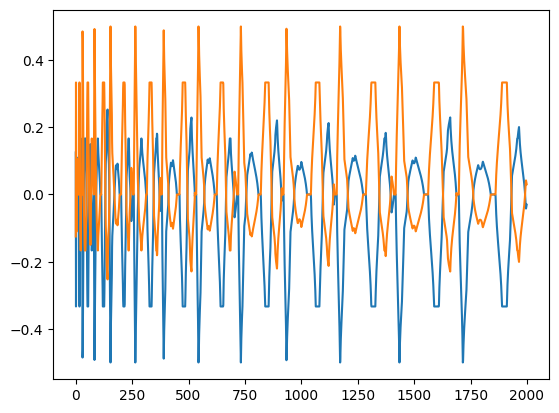

In [37]:
plt.plot(np.arange(T), p1_utility)
plt.plot(np.arange(T), p2_utility)
plt.show()

Expected image: \\
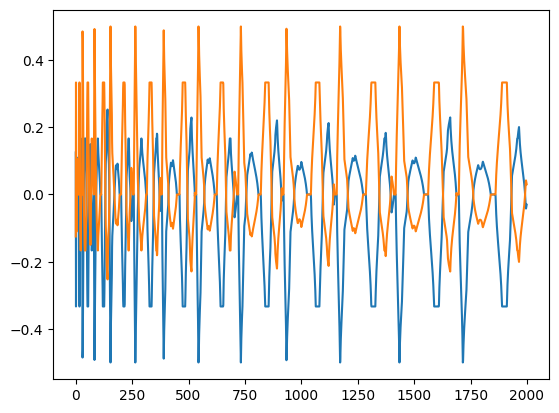

In [38]:
print('Optimal strategies for player 1 are:')
for k, v in info_sets.items():
    if len(k) % 2 == 0:
        print(k, np.round(v.get_average_strategy(), 2))

print('Optimal strategies for player 2 are:')
for k, v in info_sets.items():
    if len(k) % 2 == 1:
        print(k,np.round(v.get_average_strategy(), 2))

Optimal strategies for player 1 are:
K rr [0.61 0.39]
K rrcb [1. 0.]
Q rr [0. 1.]
Q rrcb [0.54 0.46]
J rr [0.19 0.81]
J rrcb [0. 1.]
Optimal strategies for player 2 are:
Q rrb [0.33 0.67]
Q rrc [0. 1.]
J rrb [0. 1.]
J rrc [0.35 0.65]
K rrb [1. 0.]
K rrc [1. 0.]


## CFRM+ Utility and Equilibrium Strategy

In [39]:
T = 2000
# dictionary containing all the information sets
info_sets = {}
# list to keep track of utilities for each player
p1_utility = []
p2_utility = []

for i in range(T):
    # keeping track of cumulative utilities for all iterations
    p1_utility.append(cvalue_p1(info_sets))
    p2_utility.append(cvalue_p2(info_sets))
    for key in info_sets:
        # updating strategy after a full iteration
        info_sets[key].next_strategy('RM+')

# finding average utility of the game
p1_avg_utility = np.mean(p1_utility)
p2_avg_utility = np.mean(p2_utility)

In [40]:
print('Player 1s expected value = ')
print(p1_avg_utility)
print('Player 2s expected value = ')
print(p2_avg_utility)
print('Theoretical bound')
print(1/18)

Player 1s expected value = 
-0.05397695465395633
Player 2s expected value = 
0.05397695465395633
Theoretical bound
0.05555555555555555


You should get something close to: \\
Player 1s expected value = -0.05397695465395633 \\
Player 2s expected value =  0.05397695465395633 \\

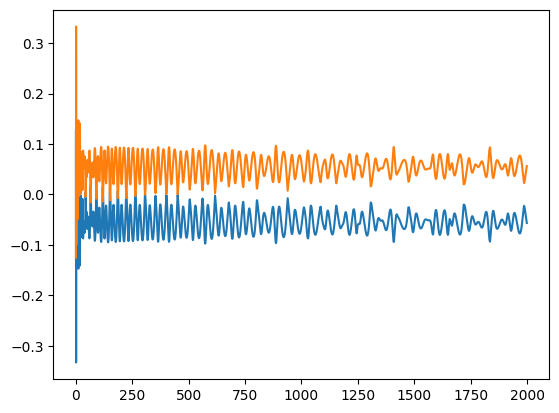

In [41]:
plt.plot(np.arange(T), p1_utility)
plt.plot(np.arange(T), p2_utility)
plt.show()

Expected image:

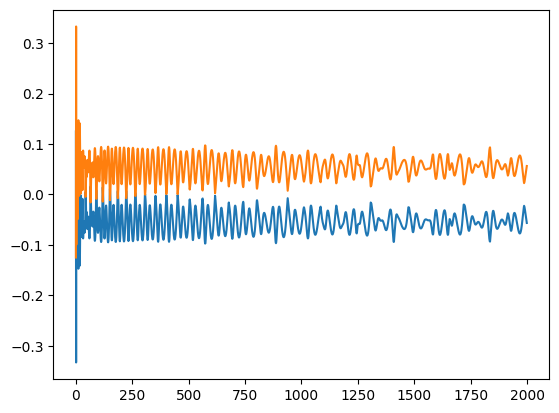

In [42]:
print('Optimal strategies for player 1 are:')
for k, v in info_sets.items():
    if len(k) % 2 == 0:
        print(k, np.round(v.get_average_strategy(), 2))

print('Optimal strategies for player 2 are:')
for k, v in info_sets.items():
    if len(k) % 2 == 1:
        print(k,np.round(v.get_average_strategy(), 2))

Optimal strategies for player 1 are:
K rr [0.8 0.2]
K rrcb [1. 0.]
Q rr [0. 1.]
Q rrcb [0.6 0.4]
J rr [0.26 0.74]
J rrcb [0. 1.]
Optimal strategies for player 2 are:
Q rrb [0.36 0.64]
Q rrc [0. 1.]
J rrb [0. 1.]
J rrc [0.34 0.66]
K rrb [1. 0.]
K rrc [1. 0.]


(1 point) What differences do you observe for CFRM and CFRM+? Why do you think this is the case?

It seems like the CFRM+ algorithm stabilizes to a much higher degree when it came to expected returns of the players than the standard CFRM algorithm. We saw a very high variance in the CFRM algorithm with expected returns for Player 1 oscillating between ~0.5 to ~-0.2, even when T increased into the thousands, while the CFRM+ algorithm stabilized to Player 1's expected return being between 0.0 and 0.1 as T got large. I believe this might have to do with a continuous overcorrection that occurs when factoring in negative regrets for the standard CFRM algorithm that prevents the algorithm from ever truly seeming to converge.